(-3.0, 3.0)

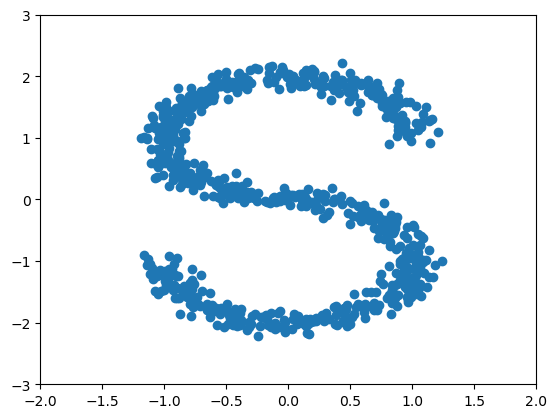

In [1]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_s_curve
from sklearn.model_selection import train_test_split
import numpy as np
import torch
import random

# Fix seeds for reproducibility
np.random.seed(0)
random.seed(0)
torch.manual_seed(0)

# Number of bins and limits for plotting
n_bins_x = 20
n_bins_y = 30
x_min = -2
x_max = 2
y_min = -3
y_max = 3
x_array = np.linspace(x_min, x_max, n_bins_x+1)
y_array = np.linspace(y_min, y_max, n_bins_y+1)

samples, labels = make_s_curve(n_samples=1000, noise=0.1)
training_data, validation_data = train_test_split(
    samples[:, [0, 2]],
    test_size=0.2,
    shuffle=True,
)

# Plot the training data
plt.figure()
plt.scatter(training_data[:, 0], training_data[:, 1])
plt.xlim((x_min, x_max))
plt.ylim((y_min, y_max))

In [2]:
device = torch.device('cpu')

def get_loader(data):
    data = torch.tensor(data.astype(np.float32)).to(device)
    sampler = torch.utils.data.RandomSampler(
        data_source=data,
        num_samples=2**13,
        replacement=True,
    )
    loader = torch.utils.data.DataLoader(
        dataset=torch.utils.data.TensorDataset(data),
        batch_size=512,
        sampler=sampler,
    )

    return loader

training_loader = get_loader(training_data)
validation_loader = get_loader(validation_data)

In [7]:
!pip install POT

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 1.8 MB/s eta 0:00:00:00:01


In [8]:
import torch.nn as nn
from wnae import WNAE

class Encoder(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.layer1 = nn.Linear(input_size, 32)
        self.layer2 = nn.Linear(32, 32)

    def forward(self, x):
        x = self.layer1(x)
        x = nn.functional.relu(x)
        x = self.layer2(x)
        x = nn.functional.relu(x)
        return x

class Decoder(nn.Module):
    def __init__(self, output_size):
        super().__init__()
        self.layer1 = nn.Linear(32, 32)
        self.layer2 = nn.Linear(32, output_size)

    def forward(self, x):
        x = self.layer1(x)
        x = nn.functional.relu(x)
        x = self.layer2(x)
        return x

wnae_parameters = {
    "sampling": "pcd",
    "n_steps": 10,
    "step_size": None,
    "noise": 0.2,
    "temperature": 0.05,
    "bounds": (-3, 3),
    "mh": False,
    "initial_distribution": "gaussian",
    "replay": True,
    "replay_ratio": 0.95,
    "buffer_size": 10000,
}

model = WNAE(
    encoder=Encoder(input_size=2),
    decoder=Decoder(output_size=2),
    **wnae_parameters,
)

model.to(device)

WNAE(
  (encoder): Encoder(
    (layer1): Linear(in_features=2, out_features=32, bias=True)
    (layer2): Linear(in_features=32, out_features=32, bias=True)
  )
  (decoder): Decoder(
    (layer1): Linear(in_features=32, out_features=32, bias=True)
    (layer2): Linear(in_features=32, out_features=2, bias=True)
  )
)

In [11]:
from tqdm import tqdm

def make_reco_error_map(model):
    model.eval()
    soboleng = torch.quasirandom.SobolEngine(dimension=2)
    sobol_draw = soboleng.draw(40)
    reco_errors = []
    for x_edge in x_array[:-1]:
        for y_edge in y_array[:-1]:
            x = sobol_draw[:, 0] * (x_max - x_min) / n_bins_x + x_edge
            y = sobol_draw[:, 1] * (y_max - y_min) / n_bins_y + y_edge
            data = torch.stack((x, y), dim=1)
            # Can use the evaluate method to only perform the evaluation
            reco_error = torch.mean(model.evaluate(data)["reco_errors"]).item()
            reco_errors.append([x_edge, y_edge, reco_error])

    reco_errors = np.array(reco_errors)
    return reco_errors


def run_training(model, loss_function, n_epochs, plot_epochs):

    optimizer = torch.optim.AdamW(
        params=model.parameters(),
        lr=3e-4,
    )

    training_losses = []
    validation_losses = []
    mcmc_samples_list = []
    reco_error_maps = []

    for i_epoch in range(n_epochs):

        # Train step
        model.train()
        n_batches = 0
        training_loss = 0
        bar_format = f"Epoch {i_epoch}/{n_epochs}: " \
            + "{l_bar}{bar:10}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}]"
        for batch in tqdm(training_loader, bar_format=bar_format):
            n_batches += 1
            x = batch[0]

            optimizer.zero_grad()
            # Use the `train_step` method to compute the loss
            if loss_function == "wnae":
                loss, training_dict = model.train_step(x)
            elif loss_function == "nae":
                loss, training_dict = model.train_step_nae(x)
            elif loss_function == "ae":
                loss, training_dict = model.train_step_ae(x, run_mcmc=True, mcmc_replay=True)
            loss.backward()
            optimizer.step()

            training_loss += training_dict["loss"]

        training_loss /= n_batches
        training_losses.append(training_loss)

        # Validation step
        model.eval()
        n_batches = 0
        validation_loss = 0
        for batch in validation_loader:
            n_batches += 1
            x = batch[0]

            # Use the `validation_step` method to get the loss without
            # changing the internal state of the model
            if loss_function == "wnae":
                validation_dict = model.validation_step(x)
            elif loss_function == "nae":
                validation_dict = model.validation_step_nae(x)
            elif loss_function == "ae":
                validation_dict = model.validation_step_ae(x, run_mcmc=True)
            validation_loss += validation_dict["loss"]
            # Only store the MCMC samples for visualization purpose for a few batches
            if n_batches == 1 and i_epoch in plot_epochs:
                mcmc_samples_list.append(validation_dict["mcmc_data"]["samples"][-1])
                reco_error_maps.append(make_reco_error_map(model))

        validation_loss /= n_batches
        validation_losses.append(validation_loss)

    return training_losses, validation_losses, mcmc_samples_list, reco_error_maps


# plot_epochs = [0, 10, 20, 30, 50, 80, 120, 160, 199]
# n_epochs = 200

plot_epochs = [0, 5, 10, 15, 19]
n_epochs = 20

training_losses, validation_losses, mcmc_samples_list, reco_error_maps = \
    run_training(model, "wnae", n_epochs, plot_epochs)

Epoch 19/20: 100%|██████████| 16/16 [00:00<00:00]


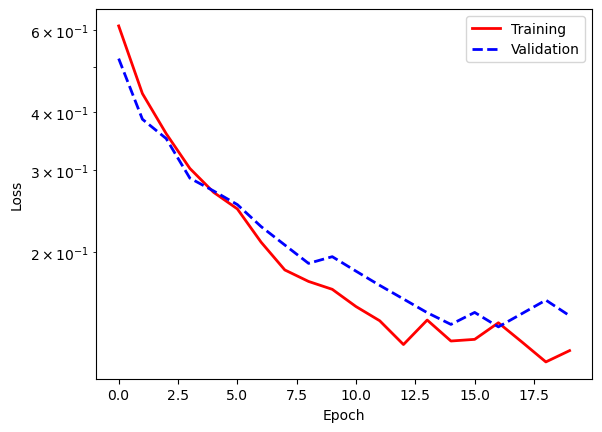

In [12]:
epochs = list(range(n_epochs))
plt.figure()
plt.plot(
    epochs,
    training_losses,
    color='red',
    linestyle='solid',
    linewidth=2,
    label="Training",
)
plt.plot(
    epochs,
    validation_losses,
    color='blue',
    linestyle='dashed',
    linewidth=2,
    label="Validation",
)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.yscale("log")
plt.legend()

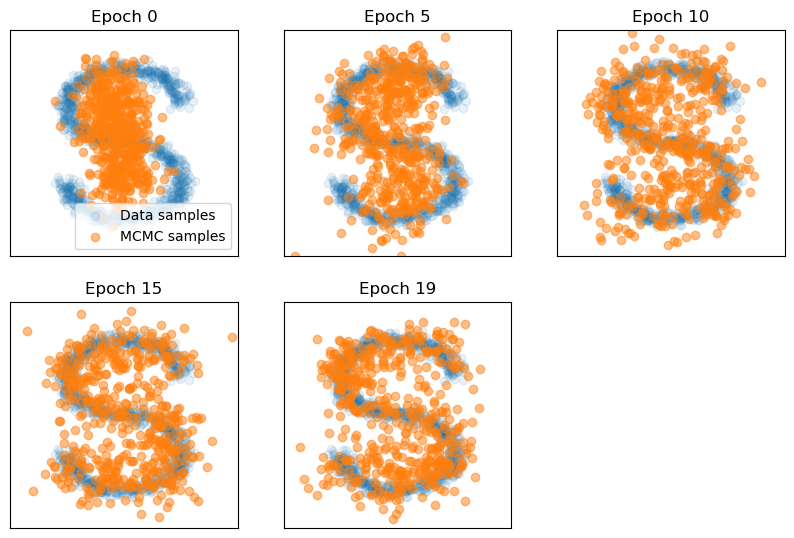

In [13]:
def plot_mcmc_samples(mcmc_samples_list):

    plt.figure(figsize=(10, 10))

    for i in range(len(mcmc_samples_list)):
        mcmc_samples = mcmc_samples_list[i]
        epoch = plot_epochs[i]
        plt.subplot(3, 3, i + 1)
        plt.scatter(samples[:, 0], samples[:, 2], label='Data samples', alpha=0.1)
        plt.scatter(mcmc_samples[:, 0], mcmc_samples[:, 1], label='MCMC samples', alpha=0.5)
        plt.xticks(())
        plt.yticks(())
        plt.xlim((x_min, x_max))
        plt.ylim((y_min, y_max))
        plt.title('Epoch {}'.format(epoch))
        if i == 0:
            plt.legend()

plot_mcmc_samples(mcmc_samples_list)

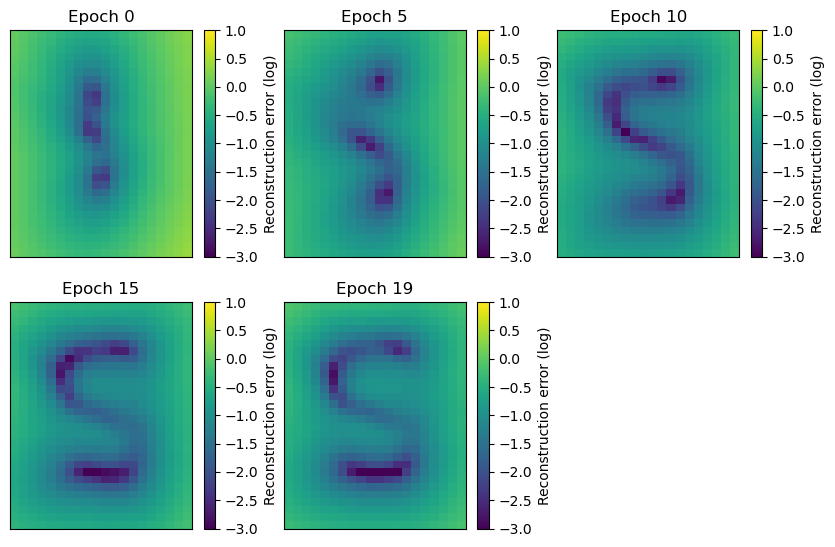

In [14]:
def plot_reco_errors(reco_error_maps):

    plt.figure(figsize=(10, 10))

    for i in range(len(reco_error_maps)):
        reco_error_map = reco_error_maps[i]
        epoch = plot_epochs[i]
        plt.subplot(3, 3, i + 1)
        h = plt.hist2d(reco_error_map[:, 0], reco_error_map[:, 1],
                    bins=(x_array, y_array),
                    weights=np.log10(reco_error_map[:, 2]))
        cbar = plt.colorbar(h[3])
        cbar.set_label("Reconstruction error (log)")
        plt.xticks(())
        plt.yticks(())
        plt.xlim((x_min, x_max))
        plt.ylim((y_min, y_max))
        plt.clim((-3, 1))
        plt.title('Epoch {}'.format(epoch))

plot_reco_errors(reco_error_maps)

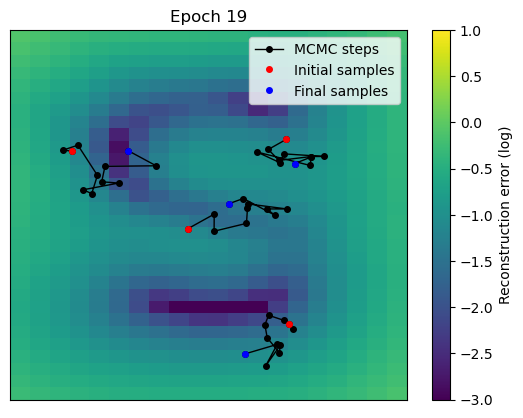

In [16]:
plt.figure()

# Generate random initial points for the MCMC
n_points = 4
x = torch.rand(n_points, 1) * (x_max - x_min) + x_min
y = torch.rand(n_points, 1) * (y_max - y_min) + y_min
initial_state = torch.hstack((x, y))

# Plot the reco error landscape
epoch = plot_epochs[-1]
h = plt.hist2d(
    reco_error_maps[-1][:, 0],
    reco_error_maps[-1][:, 1],
    bins=(x_array, y_array),
    weights=np.log10(reco_error_maps[-1][:, 2]),
)
cbar = plt.colorbar(h[3])
cbar.set_label("Reconstruction error (log)")
plt.xticks(())
plt.yticks(())
plt.xlim((x_min, x_max))
plt.ylim((y_min, y_max))
plt.clim((-3, 1))

# Run the MCMC
mcmc_samples = model.run_mcmc(x=initial_state, all_steps=True)

# Plot MCMC samples evolution
for i in range(len(mcmc_samples)):
    if i == 0:
        label0 = {"label": "MCMC steps"}
    else:
        label0 = {}
    plt.plot(mcmc_samples[i, 0, :], mcmc_samples[i, 1, :], "ko-",
             markersize=4, linewidth=1, **label0)

# Highlight initial and final steps
plt.plot(mcmc_samples[:, 0, 0], mcmc_samples[:, 1, 0], "ro",
         markersize=4, linewidth=1, label="Initial samples")
plt.plot(mcmc_samples[:, 0, -1], mcmc_samples[:, 1, -1], "bo",
         markersize=4, linewidth=1, label="Final samples")

plt.xticks(())
plt.yticks(())
plt.xlim((x_min, x_max))
plt.ylim((y_min, y_max))
plt.title('Epoch {}'.format(epoch))
plt.legend()

In [18]:
# Fix seeds for reproducibility
np.random.seed(0)
random.seed(0)
torch.manual_seed(0)

nae_model = WNAE(
    encoder=Encoder(input_size=2),
    decoder=Decoder(output_size=2),
    **wnae_parameters,
)

nae_model.to(device)
plot_epochs = [0, 5, 10, 15, 19]
n_epochs = 20

# Run NAE training
training_losses, validation_losses, mcmc_samples_list, reco_error_maps = \
    run_training(nae_model, "nae", n_epochs, plot_epochs)

Epoch 19/20: 100%|██████████| 16/16 [00:00<00:00]


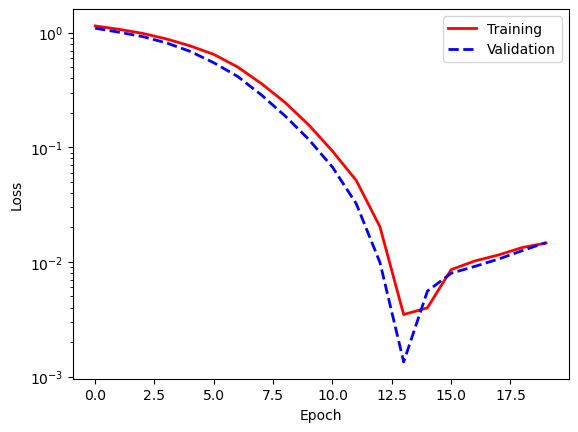

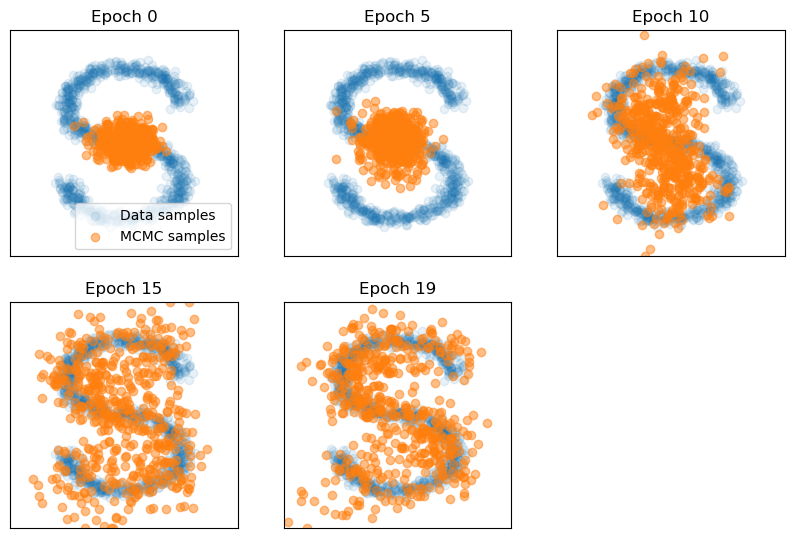

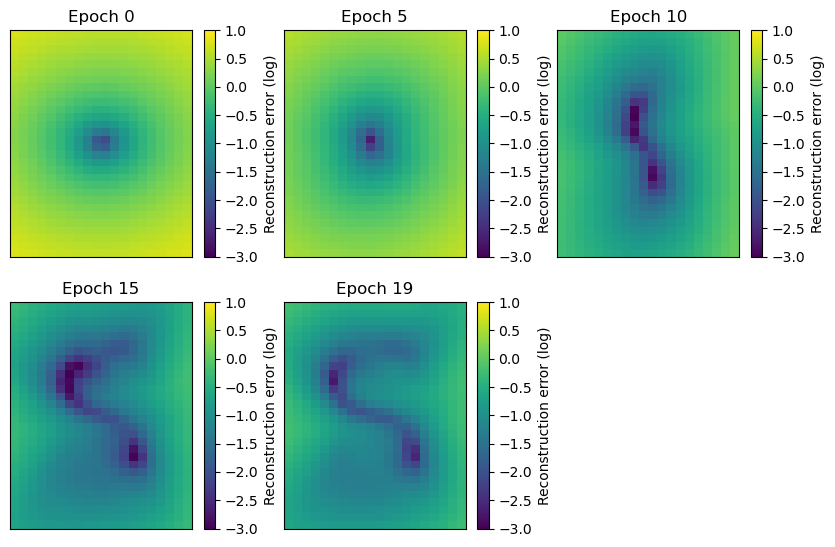

In [19]:
# Plot the loss
epochs = list(range(n_epochs))
plt.figure()
plt.plot(
    epochs,
    [abs(x) for x in training_losses],
    color='red',
    linestyle='solid',
    linewidth=2,
    label="Training",
)
plt.plot(
    epochs,
    [abs(x) for x in validation_losses],
    color='blue',
    linestyle='dashed',
    linewidth=2,
    label="Validation",
)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.yscale("log")
plt.legend()

# Plot MCMC samples
plot_mcmc_samples(mcmc_samples_list)

# Plot reco error landscape
plot_reco_errors(reco_error_maps)